In [ ]:
!pip install distinctipy shapely

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.6 MB/s eta 0:00:00


In [ ]:
# for data wrangling
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import distinctipy
from collections import defaultdict

from torch_geometric.utils import from_networkx
import shapely
# from shapely import Point, MultiPolygon, GeometryCollection, Polygon, ops, LineString, unary_union, intersection_all
from shapely.geometry import Point, MultiPolygon, Point, LineString, box
import shapely.affinity as aff
from shapely.wkt import loads
import geopandas as gpd

In [ ]:
from shapely.ops import unary_union
import shapely.affinity as aff
from shapely.wkt import loads
import geopandas as gpd

In [ ]:
room_embeddings = {
    'living': 0,
    'room': 1,
    'kitchen': 2,
    'bathroom': 3,
    'balcony': 4
}


poly_types = list(room_embeddings.keys())
N = len(poly_types)
colors = (np.array(distinctipy.get_colors(N, pastel_factor=0.7)) * 255).astype(np.uint8)
room_color = {room_name: colors[i] for i, room_name in enumerate(poly_types)}

## Attach User-Input -> Finetuned LLM here

## Graph to Floor Generation (GNN based model that is more reliable than Stable Diffusion)

In [ ]:
boundary_wkt = "POLYGON ((25.599999999999994 63.28319999999999, 230.4 63.28319999999999, 230.4 115.71199999999999, 205.82399999999998 115.71199999999999, 205.82399999999998 192.7168, 25.599999999999994 192.7168, 25.599999999999994 63.28319999999999))"

front_door_wkt = "POLYGON ((208.3342940100098 186.32118969813726, 208.3342940100098 171.7716103018627, 205.82399999999998 171.7716103018627, 205.82399999999998 186.32118969813726, 208.3342940100098 186.32118969813726))"

room_centroids  = [(60, 94), (62, 160)]
bathroom_centroids = [(108, 82)]
kitchen_centroids = [(209, 88)]

flip = False

In [ ]:
# Getting the boundary & front door as shapely polygons
from shapely import wkt
boundary_wkt = "POLYGON ((25.599999999999994 63.28319999999999, 230.4 63.28319999999999, 230.4 115.71199999999999, 205.82399999999998 115.71199999999999, 205.82399999999998 192.7168, 25.599999999999994 192.7168, 25.599999999999994 63.28319999999999))"

front_door_wkt = "POLYGON ((208.3342940100098 186.32118969813726, 208.3342940100098 171.7716103018627, 205.82399999999998 171.7716103018627, 205.82399999999998 186.32118969813726, 208.3342940100098 186.32118969813726))"

boundary = wkt.loads(boundary_wkt)
front_door = wkt.loads(front_door_wkt)

# Flipping the y axis of all data as it comes flipped from the first model.
if flip == True:
    boundary   = scale(boundary)
    front_door = scale(front_door)
    room_centroids = [scale(x) for x in room_centroids]
    bathroom_centroids = [scale(x) for x in bathroom_centroids]
    kitchen_centroids = [scale(x) for x in kitchen_centroids]

In [ ]:
color_palette = {
    'living': '#6495ED',  # Cornflower Blue
    'room': '#F4A460',    # Sandy Brown
    'bathroom': '#2E8B57',# Sea Green
    'kitchen': '#D2691E', # Chocolate
    'door': '#CD853F'     # Door color
}

In [ ]:
def Handling_dubplicated_nodes(boundary, door):

    coords = boundary.exterior.coords[:]

    # creating points:
    points = []
    for p in coords:
        points.append(Point(p))

    graph = nx.Graph()
    # type of the node: 0 for boundary, 1 for front_door
    graph.add_node(0, type=0, centroid=coords[0])

    # to save the index if there is a node will not be added
    current = 0
    name = 1

    for i in range(1, len(coords)):
        dis = points[i].distance(points[current])
        if dis >= 5:
            # type of the node, edge = 0, front_door = 1
            graph.add_node(name, type=0, centroid=coords[i])
            current = i
            name += 1

    # Checking the distance between first and last node [if the distance is small, so we will consider them the same point]
    nodes_names = list(graph.nodes)
    first_node = Point(graph.nodes[nodes_names[0]]['centroid'])
    last_node  = Point(graph.nodes[nodes_names[-1]]['centroid'])
    if first_node.distance(last_node) <= 5:
        graph.remove_node(nodes_names[-1])
        nodes_names = list(graph.nodes)

    points_of_current_graph = []
    for node in graph:
        points_of_current_graph.append(Point(graph.nodes[node]['centroid']))

    # Adding edges between nodes.
    for i in range(len(nodes_names)-1):
        dis = points_of_current_graph[i].distance(points_of_current_graph[i+1])
        graph.add_edge(nodes_names[i],nodes_names[i+1], distance=dis)

    # Adding an edge between the last and the first nodes.
    dis = points_of_current_graph[nodes_names[0]].distance(points_of_current_graph[nodes_names[-1]])

    graph.add_edge(nodes_names[0], nodes_names[-1], distance=dis)

    # adding the front door
    graph = adding_door(graph, door, points_of_current_graph)

    return graph

def adding_door(boundary_graph, door, points):
    """
    This function is used to add the front door to the boundary graph.
    Input:
        boundary graph: graph of the boundary of the floor plan.
        door: front door as polygon.
        points: list of the points of the boundary graph. to use it to detect best place for the door.
    """
    nearest_edge = None
    nearest_dist = float('inf')

    dx = door.bounds[2] - door.bounds[0]
    dy = door.bounds[3] - door.bounds[1]
    door_oriantation_horizontal = dx > dy

    for edge in boundary_graph.edges():
        p1 = points[edge[0]]
        p2 = points[edge[1]]

        line = LineString([p1, p2])

        # checking the oriantation of the lines.
        p1x, p1y = p1.x, p1.y
        p2x, p2y = p2.x, p2.y
        dx = abs(p2x - p1x)
        dy = abs(p2y - p1y)
        line_oriantation_horizontal = dx > dy

        # print(f'edge: {edge}, line is: {line_oriantation_horizontal}, door is: {door_oriantation_horizontal}')
        if door_oriantation_horizontal == line_oriantation_horizontal:
            # getting nearest - with same oriantation - edge
            dist = door.distance(line)
            if dist < nearest_dist:
                nearest_dist = dist
                nearest_edge = edge

    # print(f'nearest is: {nearest_edge}')
    boundary_graph.remove_edge(*nearest_edge)

    door_ind = len(boundary_graph)
    door_centroid = door.centroid
    boundary_graph.add_node(door_ind, type=1, centroid=(door_centroid.x, door_centroid.y))

    dist = door_centroid.distance(Point(boundary_graph.nodes[nearest_edge[0]]['centroid']))
    boundary_graph.add_edge(nearest_edge[0], door_ind, distance=dist)

    dist = door_centroid.distance(Point(boundary_graph.nodes[nearest_edge[1]]['centroid']))
    boundary_graph.add_edge(nearest_edge[1], door_ind, distance=dist)

    return boundary_graph

def centroids_to_graph(floor_plan, living_to_all=False, all_conected=False):
    """
    Generating a graph for a specific floor plan

    Input:
        floor_plan: a dictionary [key: type of room, value: list of centroids]
        living_to_all: boolean, if True, we will connect all rooms to the living room.
        all_conected: boolean, if True, we will connect all rooms to each other.

    Output:
        G: a networkx graph represents the floor plan.
    """
    # Creating new graph
    G = nx.Graph()

    # Embeding each room in a node.
    for type_, list_of_centroids in floor_plan.items():
        for i, centroid in enumerate(list_of_centroids):

            currentNodeName = f'{type_}_{i}'
            G.add_node(currentNodeName,
                roomType_name = type_,
                roomType_embd = room_embeddings[type_],
                actualCentroid_x = centroid[0],
                actualCentroid_y = centroid[1])


    # if we need to connect all nodes to the living
    if living_to_all:
        living_cen = Point(G.nodes['living_0']['actualCentroid_x'], G.nodes['living_0']['actualCentroid_y'])
        for node in G.nodes():
                if G.nodes[node]['roomType_name'] != 'living':
                    point = Point(G.nodes[node]['actualCentroid_x'], G.nodes[node]['actualCentroid_y'])
                    dis = living_cen.distance(point)
                    # adding edges between the living and all geoms
                    G.add_edge('living_0', node, distance=round(dis, 3))

    # if we need to connect all nodes to each others
    if all_conected:
        for node in G.nodes():
            current_node_centeroid = Point(G.nodes[node]['actualCentroid_x'], G.nodes[node]['actualCentroid_y'])

            for other_node in G.nodes():
                if other_node != node: # for all other rooms
                    other_node_centeroid = Point(G.nodes[other_node]['actualCentroid_x'], G.nodes[other_node]['actualCentroid_y'])

                    dis = current_node_centeroid.distance(other_node_centeroid)
                    # adding edges between the the current node and the other nodes
                    G.add_edge(node, other_node, distance=round(dis, 3))

    return G

def boundary_to_image(boundary_wkt, front_door_wkt):
    boundary = shapely.wkt.loads(boundary_wkt)
    front_door = shapely.wkt.loads(front_door_wkt)

    gpd.GeoSeries([boundary, front_door]).plot(cmap='tab10');
    plt.xlim(0, 256);
    plt.ylim(0, 256);
    plt.axis('off');

    plt.savefig('./Outputs//boundary.png')
    plt.close()

def get_user_inputs_as_image(boundary, front_door, room_centroids, bathroom_centroids, kitchen_centroids):
    polys = defaultdict(list)

    for center in room_centroids:
        polys['room'].append(Point(center))

    for center in bathroom_centroids:
        polys['bathroom'].append(Point(center))

    for center in kitchen_centroids:
        polys['kitchen'].append(Point(center))

    Input_format = []
    Input_format.append(boundary)
    Input_format.append(front_door)

    for _, poly_list in polys.items():
        Input_format.append(unary_union(poly_list))

    Input_format = gpd.GeoSeries(Input_format)
    Input_format.plot(cmap='twilight', alpha=0.8, linewidth=0.8, edgecolor='black');

    plt.xlim(0, 256);
    plt.ylim(0, 256);

def draw_graph(G):
    pos = {node: (G.nodes[node]['actualCentroid_x'], G.nodes[node]['actualCentroid_y']) for node in G.nodes}

    colormap = [room_color[G.nodes[node]['roomType_name']]/255 for node in G]

    nx.draw(G, pos=pos, node_color=colormap, with_labels=True, font_size=12)

    # plt.xlim(-10, 266)
    # plt.ylim(-266, 10)

def draw_graph_boundary(G):
    """
    This function is used to draw the graph of the boundary of the floor plan.
    """

    #  nodes positions for drawing, note that we invert the y pos
    pos = {node: (G.nodes[node]['centroid'][0], G.nodes[node]['centroid'][1])  for node in G.nodes}

    door_color = '#90EE90'
    other_nodes_color = '#0A2A5B'
    color_map = [door_color if G.nodes[node]['type'] == 1 else other_nodes_color for node in G.nodes]

    nx.draw(G, pos=pos, with_labels=True, node_color=color_map, font_color='w', font_size=12)

    # plt.xlim(-10, 266)
    # plt.ylim(-266, 10)

def draw_both_graphs(boundary_graph, entire_graph, file_path):
    # Create a new figure
    plt.figure()

    # Draw the boundary graph in blue color
    # nx.draw(boundary_graph, with_labels=True, node_color='blue', alpha=0.7)
    draw_graph_boundary(boundary_graph)
    draw_graph(entire_graph)

    # Draw the entire graph in red color
    # nx.draw(entire_graph, with_labels=True, node_color='red', alpha=0.7)

    # Save the figure as an image
    plt.savefig(file_path)
    plt.close()  # Close the figure to free up resources

def scale(x):
    if isinstance(x, tuple):
        x = Point(*x)

    return aff.scale(x, xfact=1, yfact=-1, origin=(128, 128))

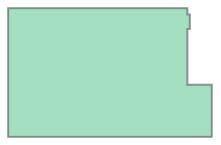

In [ ]:
boundary | front_door

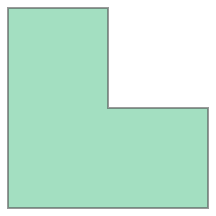

In [ ]:
boundary_wkt_1 =  "POLYGON ((0 0, 200 0, 200 100.00001, 100 100, 99.99999 200, 0 199.99999, 0 0))"
front_door_wkt_1 = "POLYGON ((89.99999 89.99999, 109.99999 90, 110 100.00001, 90.00001 99.99999, 89.99999 89.99999))"

boundary = wkt.loads(boundary_wkt_1)
front_door = wkt.loads(front_door_wkt_1)

# Flipping the y axis of all data as it comes flipped from the first model.
if flip == True:
    boundary   = scale(boundary)
    front_door = scale(front_door)
    room_centroids = [scale(x) for x in room_centroids]
    bathroom_centroids = [scale(x) for x in bathroom_centroids]
    kitchen_centroids = [scale(x) for x in kitchen_centroids]

boundary

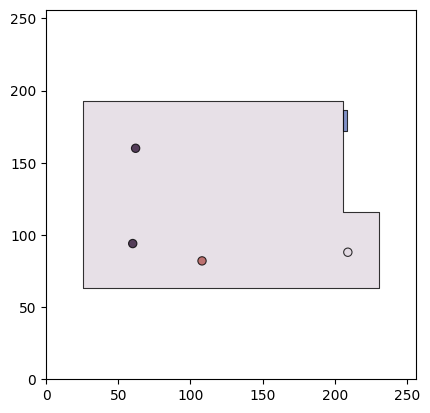

In [ ]:
get_user_inputs_as_image(boundary, front_door, room_centroids, bathroom_centroids, kitchen_centroids)


In [ ]:
if flip == True:
    room_centroids = [x.coords[0] for x in room_centroids]
    bathroom_centroids = [x.coords[0] for x in bathroom_centroids]
    kitchen_centroids = [x.coords[0] for x in kitchen_centroids]

In [ ]:
living_centroid    = [(boundary.centroid.x, boundary.centroid.y)]


In [ ]:
user_constraints = {
    'living': living_centroid,
    'room': room_centroids,
    'bathroom': bathroom_centroids,
    'kitchen': kitchen_centroids
}

G = centroids_to_graph(user_constraints, living_to_all=True)
boundary_graph = Handling_dubplicated_nodes(boundary, front_door)

# The final graph of the floor plan
draw_both_graphs(boundary_graph, G, '/content/drive/MyDrive/GAT-Net_model/Outputs/Graphs.png')

In [ ]:
# Boundary graph
B_pytorch = from_networkx(boundary_graph, group_node_attrs=['type', 'centroid'], group_edge_attrs=['distance'])

# Floor plan graph
features = ['roomType_embd', 'actualCentroid_x', 'actualCentroid_y']
G_pytorch = from_networkx(G, group_edge_attrs=['distance'], group_node_attrs=features)

In [ ]:
mean_x = G_pytorch.x[:, 1].mean().item()
mean_y = G_pytorch.x[:, 2].mean().item()

std_x = G_pytorch.x[:, 1].std().item()
std_y = G_pytorch.x[:, 2].std().item()

In [ ]:
import torch
import torch.nn.functional as F
for i in [1, 2]:
    if i == 1:
        G_pytorch.x[:, i] = (G_pytorch.x[:, i] - mean_x) / std_x
    elif i == 2:
        G_pytorch.x[:, i] = (G_pytorch.x[:, i] - mean_y) / std_y

print(G_pytorch.x)
first_column_encodings = F.one_hot(G_pytorch.x[:, 0].long(), num_classes=7).to(torch.float)
G_pytorch.x = torch.cat([first_column_encodings, G_pytorch.x[:, 1:]], dim=1)

tensor([[ 0.0000,  0.1494,  0.4888],
        [ 1.0000, -0.8577, -0.4891],
        [ 1.0000, -0.8247,  1.5287],
        [ 3.0000, -0.0662, -0.8559],
        [ 2.0000,  1.5992, -0.6725]], dtype=torch.float64)


In [ ]:
mean_bou_x = B_pytorch.x[:, 1].mean().item()
mean_bou_y = B_pytorch.x[:, 2].mean().item()

std_bou_x = B_pytorch.x[:, 1].std().item()
std_bou_y = B_pytorch.x[:, 2].std().item()

In [ ]:
import torch
import torch.nn.functional as F
for i in [1, 2]:
    if i == 1:
        B_pytorch.x[:, i] = (B_pytorch.x[:, i] - mean_bou_x) / std_bou_x
    elif i == 2:
        B_pytorch.x[:, i] = (B_pytorch.x[:, i] - mean_bou_y) / std_bou_y

B_pytorch.x

tensor([[ 0.0000, -1.4540, -1.1997],
        [ 0.0000,  0.7367, -1.1997],
        [ 0.0000,  0.7367, -0.2814],
        [ 0.0000,  0.4738, -0.2814],
        [ 0.0000,  0.4738,  1.0672],
        [ 0.0000, -1.4540,  1.0672],
        [ 1.0000,  0.4872,  0.8278]], dtype=torch.float64)

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.nn import GATConv

class GATNet(torch.nn.Module):
    def __init__(self, num_graph_node_features, num_boundary_node_features):
        super(GATNet, self).__init__()

        self.graph_conv1 = GATConv(num_graph_node_features, 32, heads=4)

        input_of_conv2   = num_graph_node_features + 32*4
        self.graph_conv2 = GATConv(input_of_conv2, 32, heads=8)

        input_of_conv3   = num_graph_node_features + 32*8
        self.graph_conv3 = GATConv(input_of_conv3, 64, heads=8)

        input_of_conv4   = num_graph_node_features + 64*8
        self.graph_conv4 = GATConv(input_of_conv4, 128, heads=8)

        shape_of_graphs_befor_concatination = num_graph_node_features + 128*8

        self.boundary_conv1 = GATConv(num_boundary_node_features, 32, heads=4)
        input_of_boundary_conv2 = 32*4 + num_boundary_node_features
        self.boundary_conv2 = GATConv(input_of_boundary_conv2, 32, heads=8)

        shape_of_boundary_befor_concatination = num_boundary_node_features + 32 * 8

        # Output of graph_conv8 + output of boundary_conv5 + 2 step connection from real nodes and boundary nodes
        inputs_concatination = shape_of_graphs_befor_concatination + shape_of_boundary_befor_concatination
        self.Concatination1  = GATConv(inputs_concatination, 128, heads=8)

        self.width_layer1  = nn.Linear(128*8, 128)
        self.height_layer1 = nn.Linear(128*8, 128)

        self.width_output  = nn.Linear(128, 1)
        self.height_output = nn.Linear(128, 1)

        self.dropout = torch.nn.Dropout(0.2)

    def forward(self, graph, boundary):
        x_graph, g_edge_index, g_edge_attr, g_batch = graph.x.to(torch.float32), graph.edge_index, graph.edge_attr, graph.batch
        x_boundary, b_edge_indexy, b_edge_attr, b_batch = boundary.x.to(torch.float32), boundary.edge_index, boundary.edge_attr, boundary.batch

        NUM_OF_NODES = x_graph.shape[0]
        if g_batch == None:
            g_batch = torch.zeros(x_graph.shape[0], dtype=torch.long)
        if b_batch == None:
            b_batch = torch.zeros(x_boundary.shape[0], dtype=torch.long)


        x_graph_res = x_graph
        x_boundary_res = x_boundary

        x_graph = F.leaky_relu(self.graph_conv1(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph)
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)


        x_graph = F.leaky_relu(self.graph_conv2(x_graph, g_edge_index, g_edge_attr))
        x_graph = self.dropout(x_graph)
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)

        x_graph = F.leaky_relu(self.graph_conv3(x_graph, g_edge_index))
        x_graph = self.dropout(x_graph)
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)

        x_graph = F.leaky_relu(self.graph_conv4(x_graph, g_edge_index))
        x_graph = self.dropout(x_graph)
        x_graph = torch.cat([x_graph, x_graph_res], dim=1)


        x_boundary = F.leaky_relu(self.boundary_conv1(x_boundary, b_edge_indexy, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
        x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)

        x_boundary = F.leaky_relu(self.boundary_conv2(x_boundary, b_edge_indexy, b_edge_attr))
        x_boundary = self.dropout(x_boundary)
        x_boundary = torch.cat([x_boundary, x_boundary_res], dim=1)

        x_boundary_pooled = F.max_pool1d(x_boundary.transpose(0, 1), kernel_size=x_boundary.shape[0]).view(1, -1)

        x = torch.cat([x_graph, x_boundary_pooled.repeat(NUM_OF_NODES, 1)], dim=1)
        x = F.leaky_relu(self.Concatination1(x, g_edge_index))
        x = self.dropout(x)


        width = F.leaky_relu(self.width_layer1(x))
        width = self.dropout(width)
        width = self.width_output(width)

        height = F.leaky_relu(self.height_layer1(x))
        height = self.dropout(height)
        height = self.height_output(height)

        return width.squeeze(), height.squeeze()

num_graph_node_features = G_pytorch.x.shape[1]
num_boundary_node_features = B_pytorch.x.shape[1]

model = GATNet(num_graph_node_features, num_boundary_node_features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
model

GATNet(
  (graph_conv1): GATConv(9, 32, heads=4)
  (graph_conv2): GATConv(137, 32, heads=8)
  (graph_conv3): GATConv(265, 64, heads=8)
  (graph_conv4): GATConv(521, 128, heads=8)
  (boundary_conv1): GATConv(3, 32, heads=4)
  (boundary_conv2): GATConv(131, 32, heads=8)
  (Concatination1): GATConv(1292, 128, heads=8)
  (width_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (height_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (width_output): Linear(in_features=128, out_features=1, bias=True)
  (height_output): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
# torch.save(model, "/content/drive/MyDrive/GAT-Net_model/checkpoints/GAT-Net_v3_UnScalled.pt")

In [ ]:
checkpoint_path = "/content/drive/MyDrive/GAT-Net_model/checkpoints/GAT-Net_v3_UnScalled.pt"
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


model.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epochs = checkpoint['epoch']

model.eval()

GATNet(
  (graph_conv1): GATConv(9, 32, heads=4)
  (graph_conv2): GATConv(137, 32, heads=8)
  (graph_conv3): GATConv(265, 64, heads=8)
  (graph_conv4): GATConv(521, 128, heads=8)
  (boundary_conv1): GATConv(3, 32, heads=4)
  (boundary_conv2): GATConv(131, 32, heads=8)
  (Concatination1): GATConv(1292, 128, heads=8)
  (width_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (height_layer1): Linear(in_features=1024, out_features=128, bias=True)
  (width_output): Linear(in_features=128, out_features=1, bias=True)
  (height_output): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
class FloorPlan_multipolygon():
    def __init__(self, graph, prediction):
        self.graph       = graph
        self.prediction  = prediction

    def get_room_data(self, room_index):
        """
        Inputs:
            room_index: index of the room in the graph

        Outputs:
            centroid, w, h of that room.
        """
        # # Using networkX graphs
        # Graph_data = list(self.graph.nodes(data=True))[room_index][1]
        # w = Graph_data['rec_w']
        # h = Graph_data['rec_h']
        # centroid = (Graph_data['actualCentroid_x'], Graph_data['actualCentroid_y'])
        # category = Graph_data['roomType_embd']

        # Using pytorhc Garphs

        centroid = (self.graph.x[room_index][-2].item(), self.graph.x[room_index][-1].item())
        category = torch.argmax(self.graph.x[:, :7], axis=1)[room_index].item()
        w_pre, h_pre = self.get_predictions(room_index)


        data = {
            'centroid': centroid,
            'predic_w': w_pre,
            'predic_h': h_pre,
            'category': category
        }
        return data

    def create_box(self, room_data):
        """
        Inputs:
            room_data: a dictionary with centroid, w, h of that room.

        Outputs:
            box: a shapely box with the same centroid, w, h of that room.
        """

        centroid = room_data['centroid']
        half_w   = room_data['predic_w'] / 2
        half_h   = room_data['predic_h'] / 2

        # bottom_left  = Point(centroid[0] - half_w, centroid[1] - half_h)
        # bottom_right = Point(centroid[0] + half_w, centroid[1] - half_h)
        # top_right    = Point(centroid[0] + half_w, centroid[1] + half_h)
        # top_left     = Point(centroid[0] - half_w, centroid[1] + half_h)

        x1 = centroid[0] - half_w
        x2 = centroid[0] + half_w
        y1 = centroid[1] - half_h
        y2 = centroid[1] + half_h

        # print(bottom_left, bottom_right, top_right, top_left)
        # box = Polygon([bottom_left, bottom_right, top_right, top_left])
        box_poly = create_shapely_box(x1, y1, x2, y2)
        return box_poly

    def get_room_type(self, room_category):
        room_type_mapping = {
            0: 'Unknown',   # Assuming '0' is an unknown category
            1: 'Living',
            2: 'Bathroom',
            3: 'Kitchen',
            # Add more mappings as necessary
        }
        return room_type_mapping.get(room_category, 'Unknown')

    def get_multipoly(self, boundary=False, door=False):
        """
        Outputs:
            multi_poly: a shapely multipolygon of all the rooms in the floor plan or graph.
        """
        num_of_rooms = self.graph.x.shape[0]
        similar_polygons = defaultdict(list)

        for index in range(num_of_rooms):
            room_data = self.get_room_data(index)
            box = self.create_box(room_data)
            #box = box.intersection(boundary.buffer(-3, cap_style=3, join_style=2))

            if box and not box.is_empty:
                similar_polygons[room_data['category']].append(box)
            else:
                print(f"Empty or None box for room index {index}, data: {room_data}")

            # add each pox to its similar boxes
            room_category = room_data['category']
            if room_category != 0:
                similar_polygons[room_category].append(box)


        all_polygons = []
        all_polygons.append(boundary)
        similar_polygons_2 = defaultdict(list)
        already_inside_bath = False
        for room_category, polygons in similar_polygons.items():
            # if room_category == 2:
            #     for poly in polygons:
            #         similar_polygons_2[room_category].append(poly)

            # elif room_category == 3:
            #     if len(polygons) == 1:
            #         similar_polygons_2[room_category].append(polygons[0])
            #     else:
            #         # check most polgon has intersection with other polygons
            #         for




            if room_category in (2, 3): # If bathroom or kitchen.
                # combined_polygon = unary_union(polygons)
                # all_polygons.append(combined_polygon)
                # for poly in polygons:
                #     similar_polygons_2[room_category].append(poly)

                for bath_or_kitchen in polygons:
                    if any(bath_or_kitchen.intersects(room) for room in similar_polygons[1]): # Chcek if the current bathroom or kitchen intersectes with any room
                        for i, room in enumerate(similar_polygons[1]):
                            if bath_or_kitchen.intersects(room):
                                intersection = bath_or_kitchen.intersection(room)
                                if (intersection.area >= (0.2 * bath_or_kitchen.area)) and (already_inside_bath == False):
                                    # new_bath_or_kitchen = intersection
                                    # print('>= 50%')
                                    bath_or_kitchen = bath_or_kitchen.intersection(room.buffer(-3, cap_style=3, join_style=2))
                                    already_inside_bath = True
                                    # bath_or_kitchen   = room.intersection(bath_or_kitchen.buffer(-3, cap_style=3, join_style=3))
                                else:
                                    # print('Not >= 50%')
                                    ## If we need to cut from the room
                                    room = room.difference(intersection.buffer(0.3))
                                    similar_polygons[1][i] = room

                                    ## If we need to cut from the bathroom or kitchen
                                    bath_or_kitchen = bath_or_kitchen.difference(intersection.buffer(4))

                    similar_polygons_2[room_category].append(bath_or_kitchen)

            else: # If rooms
                existing_polygons = []
                for poly in polygons: # for room in rooms
                    # print(f'Current poly: {poly.centroid}')
                    if any(poly.intersects(exist) for exist in existing_polygons):
                        for exist in existing_polygons:
                            if poly.intersects(exist): # If there is an intersection between current poly and the checking polygon.
                                # print(f'Intersects with: {exist.centroid}')
                                intersection = poly.intersection(exist)
                                if exist.area < poly.area:
                                    # print('1')
                                    difference_polygon = exist.difference(intersection.buffer(4))

                                    # We cut from the exist so we will remove the old version and add the new version.
                                    similar_polygons_2[room_category].remove(exist)
                                    similar_polygons_2[room_category].append(difference_polygon)

                                    # Also we add the current polygon.
                                    similar_polygons_2[room_category].append(poly)

                                    # The same step we didi in similar_polygons_2 we make it here to make the existing_polys the same.
                                    existing_polygons.remove(exist)
                                    existing_polygons.append(difference_polygon)

                                    existing_polygons.append(poly)

                                else:
                                    # print('2')
                                    difference_polygon = poly.difference(intersection.buffer(4))
                                    similar_polygons_2[room_category].append(difference_polygon)
                                    # existing_polygons.append(difference_polygon)
                                    # similar_polygons_2[room_category].append(exist)

                    else: # For the first one
                        # print('No intersection')
                        existing_polygons.append(poly)
                        similar_polygons_2[room_category].append(poly)

        print(f"Number of polygons before intersection: {sum(len(polys) for polys in similar_polygons.values())}")
        print(f"Number of polygons after intersection: {sum(len(polys) for polys in similar_polygons_2.values())}")


        for _, polygons in similar_polygons_2.items():
            all_polygons.append(MultiPolygon(polygons))

        if door:
            all_polygons.append(door)

        # Check if polygons are not empty
        for room_category, polygons in similar_polygons_2.items():
            non_empty_polygons = [p for p in polygons if not p.is_empty]
            print(f"Room category '{room_category}': {len(non_empty_polygons)} non-empty polygons")

        # Here we plot each type of room in its specific color
        fig, ax = plt.subplots()
        for room_type, polygons in similar_polygons_2.items():
            gpd.GeoSeries(polygons).plot(ax=ax, color=color_palette.get(room_type, '#dddddd'))
        # If you want to plot the boundary and door as well
        gpd.GeoSeries(boundary).plot(ax=ax, color='none', edgecolor='black', linewidth=2)
        if door:
            gpd.GeoSeries(door).plot(ax=ax, color=color_palette.get('door', 'red'))  # Choose a color for the door

        # Inside get_multipoly method, when adding text labels
        for room_category, polygons in similar_polygons_2.items():
            for poly in polygons:
                if not poly.is_empty:  # Check if the polygon is not empty
                    x, y = poly.centroid.x, poly.centroid.y
                    room_type_name = self.get_room_type(room_category)  # Convert the category number to a string
                    ax.text(x, y, room_type_name, horizontalalignment='center', verticalalignment='center', fontsize=9, color='white', weight='bold')

        fig, ax = plt.subplots()
        for room_category, polygons in similar_polygons.items():
            # Ensure we have valid polygons
            valid_polygons = [p for p in polygons if p and not p.is_empty]
            gpd.GeoSeries(valid_polygons).plot(ax=ax, color=color_palette.get(room_category, '#dddddd'))

        gpd.GeoSeries([boundary]).plot(ax=ax, color='none', edgecolor='black', linewidth=2)

        plt.show()
        compined_polygons_seperated = gpd.GeoSeries(all_polygons)

        return compined_polygons_seperated


    def get_predictions(self, room_index):
        """
        Inputs:
            room_index: index of the room in the graph
        outputs:
            w_predicted: predicted width for that room
            h_predicted: predicted width for that room
        """
        w_predicted = self.prediction[room_index, 0]
        h_predicted = self.prediction[room_index, 1]

        return w_predicted, h_predicted

In [ ]:
G_pytorch.x = G_pytorch.x.to(torch.float32)
G_pytorch.edge_attr = G_pytorch.edge_attr.to(torch.float32)
G_pytorch.edge_index = G_pytorch.edge_index.to(torch.int64)

B_pytorch.x = B_pytorch.x.to(G_pytorch.x.dtype)
B_pytorch.edge_index = B_pytorch.edge_index.to(G_pytorch.edge_index.dtype)
B_edge_attr = B_pytorch.edge_attr.to(G_pytorch.edge_attr.dtype)

In [ ]:
prediction = model(G_pytorch.to(device), B_pytorch.to(device))

w_predicted   = prediction[0].detach().cpu().numpy()
h_predicted   = prediction[1].detach().cpu().numpy()
w_predicted_rescaled = w_predicted * std_x + mean_x
h_predicted_rescaled = h_predicted * std_y + mean_y
print("Width predictions rescaled:", w_predicted_rescaled)
prediction = np.concatenate([w_predicted.reshape(-1, 1), h_predicted.reshape(-1, 1)], axis=1)
# w_h_predicted = (w_predicted, h_predicted)

Width predictions rescaled: [1777977.1 1357661.5 1351990.2 1414914.6 1878985.6]


In [ ]:
print(f"Width predictions range: {prediction[0].min().item()}, {prediction[0].max().item()}")
print(f"Height predictions range: {prediction[1].min().item()}, {prediction[1].max().item()}")


Width predictions range: 25762.037109375, 29315.90234375
Height predictions range: 22385.15625, 25168.205078125


In [ ]:
w_predicted = prediction[0]
h_predicted = prediction[1]
print("Predicted widths:", w_predicted)
print("Predicted heights:", h_predicted)

Predicted widths: [29315.902 25762.037]
Predicted heights: [22385.156 25168.205]


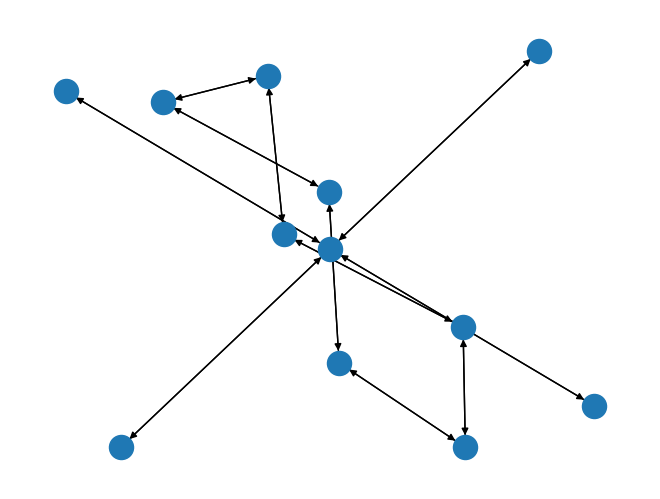

In [ ]:
from torch_geometric.utils import to_networkx
g_nx = to_networkx(G_pytorch)
b_nx = to_networkx(B_pytorch)
nx.draw(b_nx)
nx.draw(g_nx)

In [ ]:
# Get back real values of centroids to use them In the visualization
G_pytorch.x[:, -2] = G_pytorch.x[:, -2] * std_x + mean_x
G_pytorch.x[:, -1] = G_pytorch.x[:, -1] * std_y + mean_y

B_pytorch.x[:, -2] = B_pytorch.x[:, -2] * std_bou_x + mean_bou_x
B_pytorch.x[:, -1] = B_pytorch.x[:, -1] * std_bou_y + mean_bou_y

In [ ]:
G_pytorch.x[:, -2] = G_pytorch.x[:, -2] * std_x + mean_x
G_pytorch.x[:, -1] = G_pytorch.x[:, -1] * std_y + mean_y

# Print centroid values to check them
print("Centroids after rescaling:")
print(G_pytorch.x[:, -2:])


Centroids after rescaling:
tensor([[1.0086e+11, 4.8467e+09],
        [5.0759e+10, 3.6492e+09],
        [5.2400e+10, 6.1203e+09],
        [9.0134e+10, 3.1999e+09],
        [1.7299e+11, 3.4246e+09]])


In [ ]:
G_pytorch

Data(edge_index=[2, 8], roomType_name=[5], x=[5, 9], edge_attr=[8, 1])

In [ ]:
test = FloorPlan_multipolygon(G_pytorch, prediction=prediction)

Room 1 data: {'centroid': (13801394.0, 3410881.0), 'predic_w': 22385.156, 'predic_h': 25168.205, 'category': 1}
Room 2 data: {'centroid': (14247479.0, 5720523.0), 'predic_w': 22291.64, 'predic_h': 27288.785, 'category': 1}


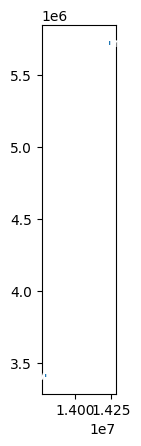

In [ ]:



from shapely.geometry import box as create_shapely_box
def create_box(room_data):
    centroid = room_data['centroid']
    half_w = room_data['predic_w'] / 2
    half_h = room_data['predic_h'] / 2

    x1 = centroid[0] - half_w
    y1 = centroid[1] - half_h
    x2 = centroid[0] + half_w
    y2 = centroid[1] + half_h

    # Use the aliased function
    box_poly = create_shapely_box(x1, y1, x2, y2)
    return box_poly

fig, ax = plt.subplots()
for index in range(1, 3):
    room_data = test.get_room_data(index)
    print(f"Room {index} data: {room_data}")  # This prints out the room data for diagnostics
    if room_data['predic_w'] > 0 and room_data['predic_h'] > 0:
        box = create_box(room_data)
        gpd.GeoSeries([box]).plot(ax=ax)
        # Add room type text labels
        room_type_name = test.get_room_type(room_data['category'])
        ax.text(room_data['centroid'][0], room_data['centroid'][1], room_type_name,
                horizontalalignment='center', verticalalignment='center', fontsize=9, color='white', weight='bold')

In [ ]:
# for index in range(2):
#     room_data = get_room_data(index)
#     print(f"Room {index} data: {room_data}")
#     box = self.create_box(room_data)
#     print(f"Created box for room {index}: {box.bounds}")

In [ ]:
G_pytorch

Data(edge_index=[2, 8], roomType_name=[5], x=[5, 9], edge_attr=[8, 1])

Number of polygons before intersection: 9
Number of polygons after intersection: 9
Room category '0': 1 non-empty polygons
Room category '1': 2 non-empty polygons
Room category '3': 2 non-empty polygons
Room category '2': 2 non-empty polygons


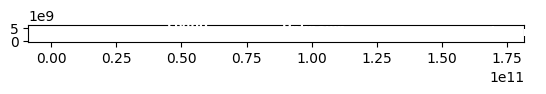

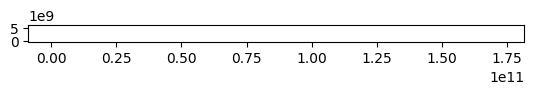

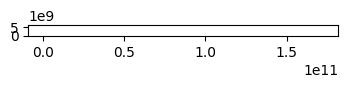

In [ ]:
# w_h_predicted = model(G.to(device), B.to(device)).detach().cpu().numpy()
test = FloorPlan_multipolygon(G_pytorch, prediction=prediction)

polys = test.get_multipoly(boundary, front_door)
polys.plot(cmap='twilight', figsize=(4, 4), alpha=0.5, linewidth=0.5, edgecolor='black');